<a href="https://colab.research.google.com/github/christakahashi/ECE447/blob/master/lectures/ODEint_example_FSFB_AND_OBSERVER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install control

     |████████████████████████████████| 256kB 4.5MB/s 
  Created wheel for control: filename=control-0.8.3-py2.py3-none-any.whl size=260982 sha256=30c2eb6b42a12a613b392905636de5764777f12563ba9187f789c032494cb704
  Stored in directory: /root/.cache/pip/wheels/c2/d9/cc/90b28cb139a6320a3af2285428b6da87eee8d8920c78bb0223
Successfully built control


In [0]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sympy import *
from matplotlib import animation
from control import *

%matplotlib inline
#comment out for light mode
plt.style.use('dark_background')

try: 
  import google.colab #test for colab
  import IPython
  def setup_typeset():
    """MathJax initialization for the current cell.
    
    This installs and configures MathJax for the current output.
    """
    IPython.display.display(IPython.display.HTML('''
        <script src="https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=TeX-AMS_HTML-full,Safe&delayStartupUntil=configured"></script>
        <script>
          (() => {
            const mathjax = window.MathJax;
            mathjax.Hub.Config({
            'tex2jax': {
              'inlineMath': [['$', '$'], ['\\(', '\\)']],
              'displayMath': [['$$', '$$'], ['\\[', '\\]']],
              'processEscapes': true,
              'processEnvironments': true,
              'skipTags': ['script', 'noscript', 'style', 'textarea', 'code'],
              'displayAlign': 'center',
            },
            'HTML-CSS': {
              'styles': {'.MathJax_Display': {'margin': 0}},
              'linebreaks': {'automatic': true},
              // Disable to prevent OTF font loading, which aren't part of our
              // distribution.
              'imageFont': null,
            },
            'messageStyle': 'none'
          });
          mathjax.Hub.Configured();
        })();
        </script>
        '''))
  def custom_latex_printer(exp,**options):
      setup_typeset()
      return printing.latex(exp,**options)
  init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)
except:
  init_printing(use_latex='mathjax')

## EXAMPLE PROBLEM
Find a controller that stabilizes the nonlinear system
\begin{align}
\dot x_1 &= -\sin(x_1)+x_2^2 + 2x_3 +u \\
\dot x_2 &= x_2^2 -3\sin(x_2) +x_3 -2u\\
\dot x_3 &= 3x_1+x_3 +2x_3^2\\
y &= x_2
\end{align}
and plot the closed loop nonlinear dynamics for the system's step response.  

In [102]:
var("x1 x2 x3 u")
xstar = {x1:0,x2:0,x3:0,u:0}
f = Matrix([[-sin(x1)+x2**2 +2*x3 +u],[x2**2 -3*sin(x2) + x3-2*u],[3*x1+x3+2*x3**2]])
y = Matrix([[x2]])
A = f.jacobian([x1,x2,x3]).subs(xstar)
B = f.jacobian([u]).subs(xstar)
C = y.jacobian([x1,x2,x3]).subs(xstar)
display(A,B,C)
A.eigenvals()

⎡-1  0   2⎤
⎢         ⎥
⎢0   -3  1⎥
⎢         ⎥
⎣3   0   1⎦

⎡1 ⎤
⎢  ⎥
⎢-2⎥
⎢  ⎥
⎣0 ⎦

[0  1  0]

{-3: 1, -√7: 1, √7: 1}

#FSFB

In [141]:
#make sure all our matrices are ndarray's.  place returns a "matrix" which 
# causes problems with computation.  
A = np.array(A).astype(np.float64)
B = np.array(B).astype(np.float64)
C = np.array(C).astype(np.float64)
K = np.array(place( A ,B,[-1,-2,-3]))
print(K)
L = np.array(place(A.transpose(),C.transpose(),[-5,-6,-7]).transpose())
print(L)
print(type(L))

[[ 3. -0.  4.]]
[[ 74.]
 [ 15.]
 [114.]]
<class 'numpy.ndarray'>


#Linear simulation using odeint

the standard observer + FSFB dynamics are
\begin{align} 
\dot x  &= A x +B u\\
\dot {\hat x}  &= A \hat x +Bu+L(y-\hat y)\\
y &= C x   \\
\hat y &= C \hat x \\
u &= -Kx+r 
\end{align}

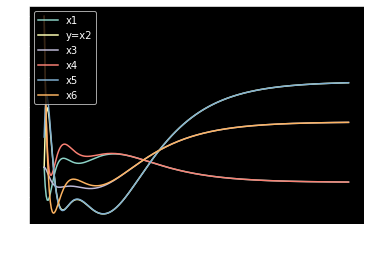

In [157]:
#our step input.  only gets called by ffn.  could be part
#of ffn but it sepparate for clarity.
def step_fn(t):
  if t>=0.:
    return 1
  else:
    return 0.

#make our nonlinear "f(x1,x2,x3,u)" into a function that evaluates to numbers
fp = lambdify([x1,x2,x3,u],f,"numpy")

#our "f" function ( defined by xdot = f(x,r)  )
def ffn(x,t ):
  #extract plant and observer dynamics and make it a column 
  xp = np.array([np.array(x[:3] )]).transpose() 
  xo = np.array([np.array(x[3:])]).transpose()
 
  #compute r 
  r = step_fn(t) 

  #### NOTE: -the @ is the same thing as matrix multiplication (np.matmul) 
  ####          but way easier to read.
  ####       - .item() turns a numpy array with one item it it into a number
  ####          eg  [[2.3]].item() -> 2.3
  ####       - numpy array * scalar value works in the way you'd expect.
  u = (r-K@xo).item()
  y = (C@xp).item()
  yhat = (C@xo).item()
   
  #compute fp(x,u) 
  xpdot = (A@xp+B*u).flatten()
  xodot = (A@xo+B*u+L*(y-yhat)).flatten()
  
  #return derivatives. 
  #making sure to put themback in the same order we got them
  return [xpdot[0],xpdot[1],xpdot[2],xodot[0],xodot[1],xodot[2]  ]
 
 
t = np.linspace(0,7,300) 
#####################################################################
## NOTE: i'm starting with the observer with a different state
## from the plant so we can see the effects.  Otherwise the observer 
## tracks perfectly and we don't even know its there.  
## This is because our observer perfectly models the plant, which
## won't be the case for the nonlinear simulation.
#####################################################################
x_of_t = spi.odeint(ffn,[0,0,0,5,1,5],t ) #start at x=(0,0,0,0,0)^T
plt.figure()
plt.plot(t,x_of_t )
#plt.ylim(-1 ,1 )
plt.legend(["x1","y=x2","x3","x4","x5","x6"],)
plt.xlabel("time") ;

#NL plot

From above, NL dynamics are:
\begin{align}
\dot x_1 &= -\sin(x_1)+x_2^2 + 2x_3 +u \\
\dot x_2 &= x_2^2 -3\sin(x_2) +x_3 -2u\\
\dot x_3 &= 3x_1+x_3 +2x_3^2\\
y &= x_2
\end{align}

\begin{align}  
\dot {\hat x}  &= A \hat x +Bu+L(y-\hat y)\\ 
\hat y &= C \hat x \\
u &= -Kx+r 
\end{align}
 


In [158]:
#some tests to see what lambdify does.
fp = lambdify([x1,x2,x3,u],f,"numpy")
print(fp(1,2,3,4)) # a 2-d column vector.
print(fp(1,2,3,4).flatten()) # a 1-d vector that'll be easier to work with later

[[13.15852902]
 [-3.72789228]
 [24.        ]]
[13.15852902 -3.72789228 24.        ]


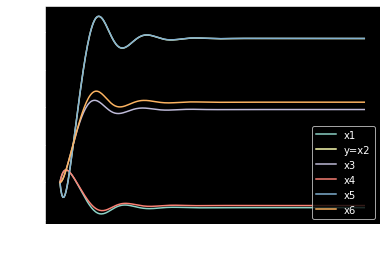

In [171]:
###################################################################
################SEE NOTE 6 lines below this line###################
###################################################################

#our step input.  only gets called by ffn.  could be part
#of ffn but it sepparate for clarity.
def step_fn(t):
  if t>=0.:
    return 0.02 #<--------NOTE PLAY WITH THIS AND SEE WHAT HAPPENS
  else:
    return 0.

#make our nonlinear "f(x1,x2,x3,u)" into a function that evaluates to numbers
fp = lambdify([x1,x2,x3,u],f,"numpy")

#our "f" function ( defined by xdot = f(x,r)  )
def ffn(x,t ):
  #extract plant and observer dynamics and make it a column 
  x1,x2,x3 = x[:3] #split out the first 3 states for the nonlinear plant.
  xo = np.array([np.array(x[3:])]).transpose()
 
  #compute r 
  r = step_fn(t) 

  #### NOTE: -the @ is the same thing as matrix multiplication (np.matmul) 
  ####          but way easier to read.
  ####       - .item() turns a numpy array with one item it it into a number
  ####          eg  [[2.3]].item() -> 2.3
  ####       - numpy array * scalar value works in the way you'd expect.
  u = (r-K@xo).item()
  y = x2
  yhat = (C@xo).item()
   
  #compute fp(x,u) 
  xpdot = fp(x1,x2,x3,u).flatten()
  xodot = (A@xo+B*u+L*(y-yhat)).flatten()
  
  #return derivatives. 
  #making sure to put themback in the same order we got them
  return [xpdot[0],xpdot[1],xpdot[2],xodot[0],xodot[1],xodot[2]  ]
 
 
t = np.linspace(0,20,300) 
#####################################################################
## NOTE: i'm starting with the observer = plant initial states here because 
## we want to give the non-linear system every chance to work since
## we don't have an exact model any more. 
#####################################################################
x_of_t = spi.odeint(ffn,[0,0,0,0,0,0],t ) #start at x=(0,0,0,0,0,0)^T
plt.figure()
plt.plot(t,x_of_t )
#plt.ylim(-1 ,1 )
plt.legend(["x1","y=x2","x3","x4","x5","x6"],)
plt.xlabel("time") ;